#| default_exp models.train

# Trainer


# Setup

In [ ]:
%cd /content/
!rm -rf /content/Whats-this-rock/
!git clone -b hydra https://github.com/udaylunawat/Whats-this-rock.git
%cd /content/Whats-this-rock/

/content
Cloning into 'Whats-this-rock'...
remote: Enumerating objects: 2093, done.
remote: Counting objects: 100% (333/333), done.
remote: Compressing objects: 100% (246/246), done.
remote: Total 2093 (delta 152), reused 188 (delta 86), pack-reused 1760
Receiving objects: 100% (2093/2093), 5.84 MiB | 2.85 MiB/s, done.
Resolving deltas: 100% (1355/1355), done.
/content/Whats-this-rock


In [ ]:
import os
os.environ['WANDB_MODE'] = 'offline' # offline

if 'WANDB_API_KEY' not in os.environ:
    if os.environ['WANDB_MODE'] == 'online':
        from getpass import getpass
        secret = getpass('Enter WandB API Key: ')
        os.environ['WANDB_API_KEY'] = secret
    else:
        print("WandB Offline!")

WandB Offline!


In [ ]:
!sh src/scripts/setup.sh
!sh src/scripts/clean_dir.sh

The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following packages will be REMOVED:
  libcudnn8-dev
The following held packages will be changed:
  libcudnn8
The following packages will be upgraded:
  libcudnn8
1 upgraded, 0 newly installed, 1 to remove and 18 not upgraded.
Need to get 430 MB of archives.
After this operation, 3,139 MB disk space will be freed.
(Reading database ... 155569 files and directories currently installed.)
Removing libcudnn8-dev (8.0.5.39-1+cuda11.1) ...
(Reading database ... 155547 files and directories currently installed.)
Preparing to unpack .../libcudnn8_8.1.0.77-1+cuda11.2_amd64.deb ...
Unpacking libcudnn8 (8.1.0.77-1+cuda11.2) over (8.0.5.39-1+cuda11.1) ...
Setting up libcudnn8 (8.1.0.77-1+cuda11.2) ...
     |████████████████████████████████| 1.8 MB 28.4 MB/s 
     |████████████████████████████████| 151 kB 74.1 MB/s 
     |████████████████████████████████| 158 kB 

In [ ]:
%load_ext autoreload
%autoreload 2
#!/usr/bin/env python
"""
Trains a model on rocks dataset
"""

import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import gc
import subprocess
import random
import click
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report
import tensorflow as tf
import tensorflow_addons as tfa

# speed improvements
from tensorflow.keras import mixed_precision

mixed_precision.set_global_policy('mixed_float16')

import wandb
from wandb.keras import WandbCallback

from absl import app

import hydra
from omegaconf import DictConfig

from src.data.preprocess import process_data
from src.models.models import get_model
from src.data.utils import get_tfds_from_dir, prepare
from src.models.utils import get_optimizer, get_model_weights_ds
from src.data.download import get_data
from src.callbacks.callbacks import get_earlystopper, get_reduce_lr_on_plateau
from src.visualization import plot


def seed_everything(seed):
    os.environ["TF_CUDNN_DETERMINISTIC"] = "1"
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

Your GPU may run slowly with dtype policy mixed_float16 because it does not have compute capability of at least 7.0. Your GPU:
  METAL, no compute capability (probably not an Nvidia GPU)
See https://developer.nvidia.com/cuda-gpus for a list of GPUs and their compute capabilities.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


ImportError: cannot import name 'get_model_weights_ds' from 'src.models.utils' (/Users/uday/Downloads/Github/Whats-this-rock2/src/models/utils.py)

In [ ]:
# Get configs from the config file.
config = get_config()

config.seed = 42
config.dataset_config.train_dataset = [1,2,3,4]
config.dataset_config.sampling = None

config.train_config.lr = 0.001
config.train_config.epochs = 50
config.train_config.loss = "categorical_crossentropy"

config.model_config.preprocess = True
config.model_config.backbone = 'resnet'
config.model_config.regularize_more = False

config.callback_config.save_model = False
config.callback_config.rlrp_factor = 0.8
config.callback_config.rlrp_patience = 1
config.callback_config.early_patience = 10


print(config)

In [ ]:
from src.train import train
from src.train import evaluate

seed_everything(config.seed)

run = wandb.init(
    project=config.wandb_config.project,
    config=config.to_dict(),
    allow_val_change=True,
)

artifact = wandb.Artifact('rocks', type='files')
artifact.add_dir('src/')
wandb.log_artifact(artifact)

print(f"\nDatasets used for Training:- {config.dataset_config.train_dataset}")

for dataset_id in config.dataset_config.train_dataset:
    get_data(dataset_id)

if not os.path.exists('data/3_tfds_dataset/train'):
    process_data(config)

train_dataset, val_dataset, test_dataset = get_tfds_from_dir(config)

labels = [
    "Basalt",
    "Coal",
    "Granite",
    "Limestone",
    "Marble",
    "Quartzite",
    "Sandstone",
]
## Update the `num_classes` and update wandb config
config.dataset_config.num_classes = 7
if wandb.run is not None:
    wandb.config.update(
        {"dataset_config.num_classes": config.dataset_config.num_classes})
    
model, history = train(config, train_dataset, val_dataset, labels)
evaluate(config, model, history, test_dataset, labels)

6/6 [==============================] - 2s 302ms/step - loss: 4.8600 - accuracy: 0.3476 - f1_score: 0.3195
Scores:  {'loss': 4.859963417053223, 'accuracy': 0.34756097197532654, 'f1_score': 0.3195052146911621}


{'Basalt': {'precision': 0.05555555555555555, 'recall': 0.045454545454545456, 'f1-score': 0.049999999999999996, 'support': 22}, 'Coal': {'precision': 0.4727272727272727, 'recall': 0.4406779661016949, 'f1-score': 0.45614035087719296, 'support': 59}, 'Granite': {'precision': 0.3333333333333333, 'recall': 0.4, 'f1-score': 0.3636363636363636, 'support': 25}, 'Limestone': {'precision': 0.3888888888888889, 'recall': 0.375, 'f1-score': 0.3818181818181819, 'support': 56}, 'Marble': {'precision': 0.34210526315789475, 'recall': 0.24074074074074073, 'f1-score': 0.2826086956521739, 'support': 54}, 'Quartzite': {'precision': 0.3291139240506329, 'recall': 0.4, 'f1-score': 0.3611111111111111, 'support': 65}, 'Sandstone': {'precision': 0.3148148148148148, 'recall': 0.3617021276595745, 'f1-score': 0.33663366336633666, 'support': 47}, 'accuracy': 0.3475609756097561, 'macro avg': {'precision': 0.31950557893262754, 'recall': 0.32336791142236515, 'f1-score': 0.31884976663733716, 'support': 328}, 'weighted 

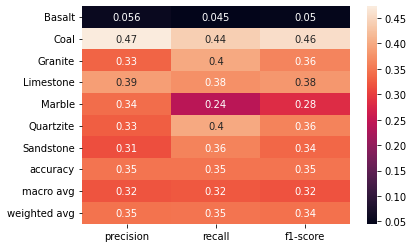

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
test_ds = prepare(test_dataset, config)
# Scores
scores = model.evaluate(test_dataset, return_dict=True)
print('Scores: ', scores)

y_true = tf.concat([y for x, y in test_ds], axis=0)
true_categories = tf.argmax(y_true, axis=1)

# Predict
y_pred = model.predict(test_dataset, verbose=1)
predicted_categories = tf.argmax(y_pred, axis=1)

# Confusion Matrix
cm = plot.plot_confusion_matrix(labels, true_categories, predicted_categories)

# Classification Report
cl_report = classification_report(true_categories,
                                  predicted_categories,
                                  labels=[0, 1, 2, 3, 4, 5, 6],
                                  target_names=labels,
                                  output_dict=True)
print(cl_report)

cr = sns.heatmap(pd.DataFrame(cl_report).iloc[:-1, :].T, annot=True)
plt.savefig('imgs/cr.png', dpi=400)

6/6 [==============================] - 2s 336ms/step - loss: 4.8600 - accuracy: 0.3476 - f1_score: 0.3195
Scores:  {'loss': 4.859963417053223, 'accuracy': 0.34756097197532654, 'f1_score': 0.3195052146911621}
6/6 [==============================] - 1s 219ms/step


{'Basalt': {'precision': 0.05263157894736842, 'recall': 0.045454545454545456, 'f1-score': 0.04878048780487805, 'support': 22}, 'Coal': {'precision': 0.5370370370370371, 'recall': 0.4915254237288136, 'f1-score': 0.5132743362831859, 'support': 59}, 'Granite': {'precision': 0.36363636363636365, 'recall': 0.32, 'f1-score': 0.3404255319148936, 'support': 25}, 'Limestone': {'precision': 0.45614035087719296, 'recall': 0.4642857142857143, 'f1-score': 0.46017699115044247, 'support': 56}, 'Marble': {'precision': 0.4, 'recall': 0.37037037037037035, 'f1-score': 0.3846153846153846, 'support': 54}, 'Quartzite': {'precision': 0.3013698630136986, 'recall': 0.3384615384615385, 'f1-score': 0.31884057971014496, 'support': 65}, 'Sandstone': {'precision': 0.3584905660377358, 'recall': 0.40425531914893614, 'f1-score': 0.38, 'support': 47}, 'accuracy': 0.38109756097560976, 'macro avg': {'precision': 0.3527579656499138, 'recall': 0.3477647016357026, 'f1-score': 0.3494447587827042, 'support': 328}, 'weighted a

Error: ignored

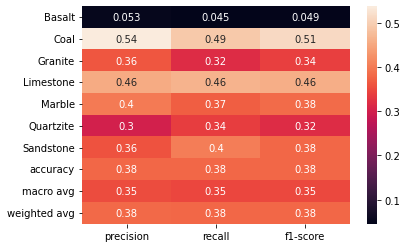

In [ ]:
test_ds = prepare(test_dataset, config)
# Scores
scores = model.evaluate(test_dataset, return_dict=True)
print("Scores: ", scores)

y_true = tf.concat([y for x, y in test_ds], axis=0)
true_categories = tf.argmax(y_true, axis=1)

# Predict
y_pred = model.predict(test_ds)
predicted_categories = tf.argmax(y_pred, axis=1)

# Confusion Matrix
cm = plot.plot_confusion_matrix(labels, true_categories,
                            predicted_categories)

# Classification Report
cl_report = classification_report(
    true_categories,
    predicted_categories,
    labels=[0, 1, 2, 3, 4, 5, 6],
    target_names=labels,
    output_dict=True,
)
print(cl_report)

cr = sns.heatmap(pd.DataFrame(cl_report).iloc[:-1, :].T, annot=True)
plt.savefig("cr.png", dpi=400)

wandb.log({"Test Accuracy": scores["accuracy"]})
wandb.log({"Test F1 Score": scores["f1_score"]})

# average of val and test f1 score
wandb.log({
    "Avg VT F1 Score":
    (scores["f1_score"] + max(history.history["val_f1_score"])) / 2
})
wandb.log({"Confusion Matrix": cm})
wandb.log({
    "Classification Report Image:":
    wandb.Image("cr.png", caption="Classification Report")
})

run.finish()